<a href="https://colab.research.google.com/github/Shrutikaa5/Image-Style-Transfer/blob/main/Image_Style_Transfer_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artistic Style Transfer with TensorFlow Lite

One of the most exciting developments in deep learning to come out recently is [artistic style transfer](https://arxiv.org/abs/1508.06576), or the ability to create a new image, known as a [pastiche](https://en.wikipedia.org/wiki/Pastiche), based on two input images: one representing the artistic style and one representing the content.

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/formula.png)

Using this technique, we can generate beautiful new artworks in a range of styles.

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

The model is open-sourced on [GitHub](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization#train-a-model-on-a-large-dataset-with-data-augmentation-to-run-on-mobile). You can retrain the model with different parameters (e.g. increase content layers' weights to make the output image look more like the content image).

## Understand the model architecture

![Model Architecture](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/architecture.png)

This Artistic Style Transfer model consists of two submodels:
1. **Style Prediciton Model**: A MobilenetV2-based neural network that takes an input style image to a 100-dimension style bottleneck vector.
1. **Style Transform Model**: A neural network that takes apply a style bottleneck vector to a content image and creates a stylized image.



## Setup

Import dependencies.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

Download the content and style images, and the pre-trained TensorFlow Lite models.

In [ ]:
content_path = tf.keras.utils.get_file('/content/horse.jpg','/content/horse.jpg')
style_path = tf.keras.utils.get_file('/content/style2.jpeg','/content/style2.jpeg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

In [ ]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


## Visualize the inputs

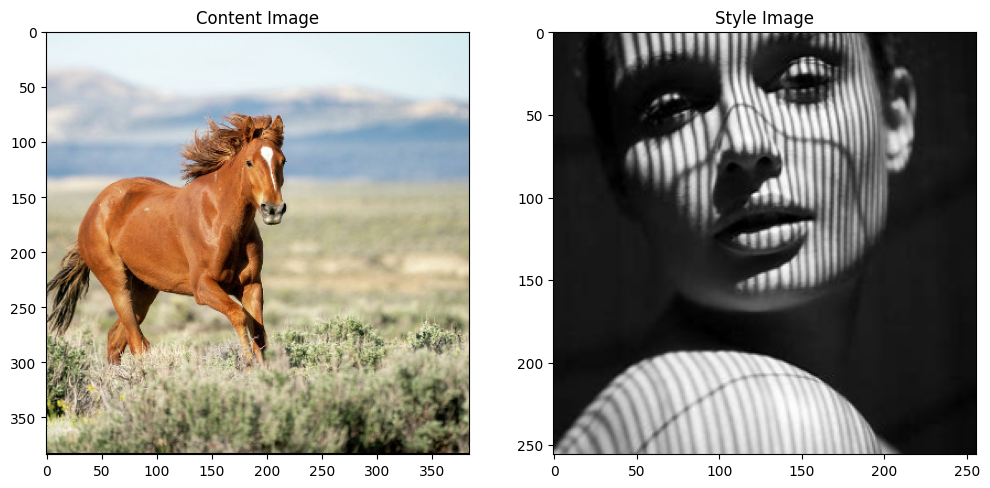

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

## Run style transfer with TensorFlow Lite

### Style prediction

In [ ]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


### Style transform

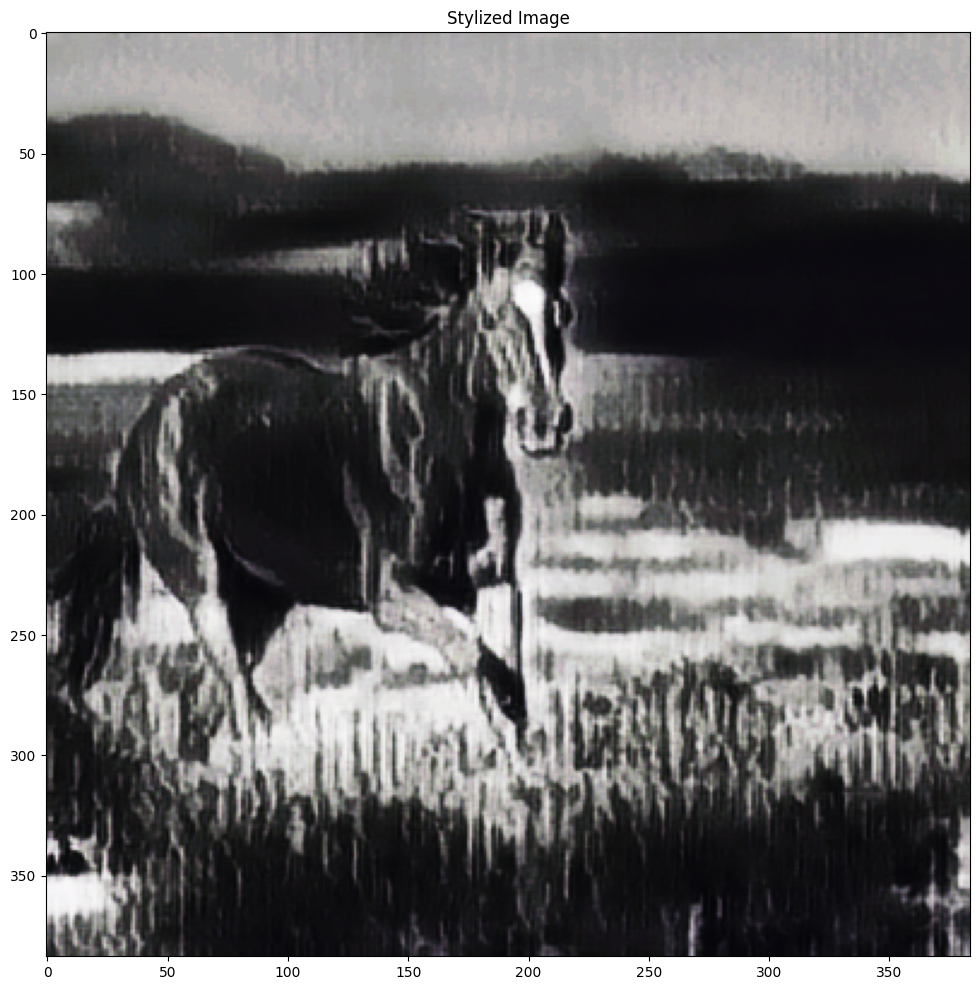

In [ ]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

### Style blending

We can blend the style of content image into the stylized output, which in turn making the output look more like the content image.

In [ ]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

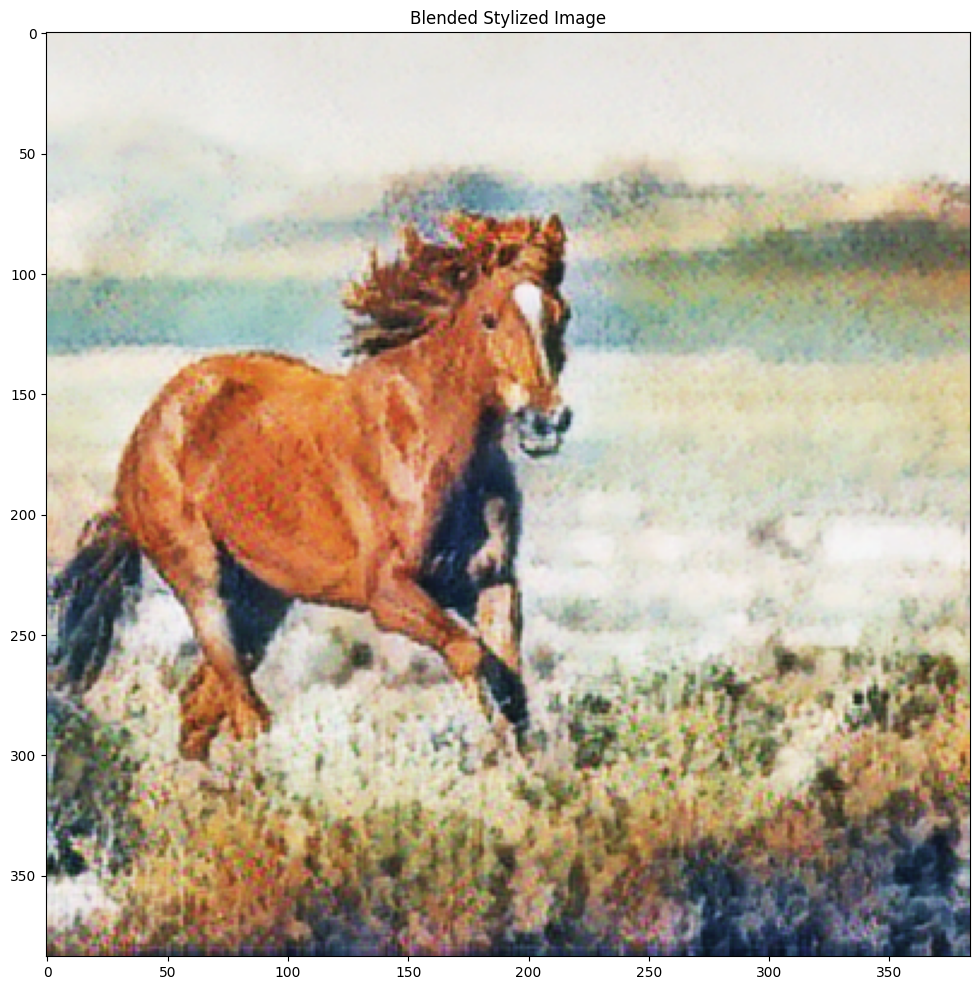

In [ ]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 1 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

Style Image Shape: (1, 256, 256, 3)
Style Bottleneck Shape: (1, 1, 1, 100)


ValueError: Cannot set tensor: Dimension mismatch. Got 3 but expected 4 for input 0.

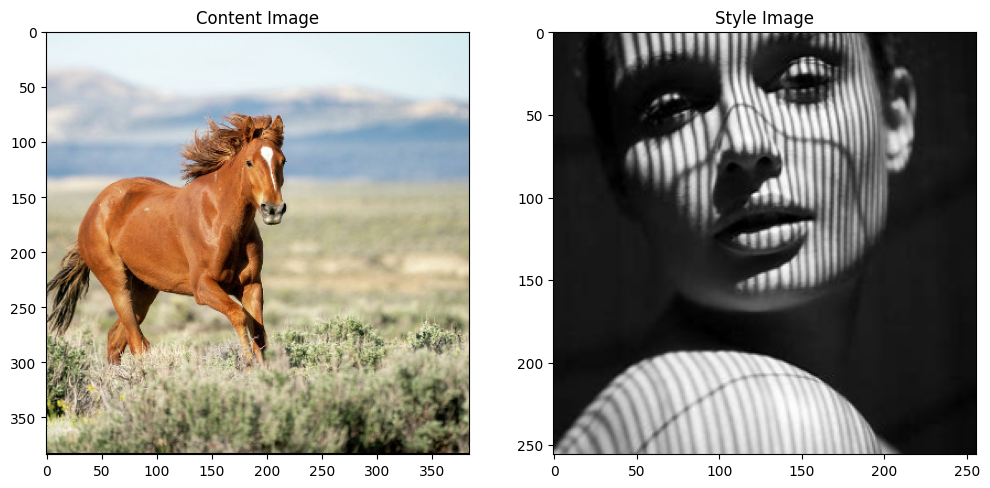

In [ ]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing and central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

# Function to extract the background of the content image.
def extract_background(content_image, threshold=0.1):
  height, width, _ = content_image.shape[1:]
  background = tf.zeros((height, width, 3))

  for i in range(height):
    for j in range(width):
      pixel = content_image[0, i, j, :]
      avg_pixel = tf.reduce_mean(pixel)
      background = tf.where(avg_pixel < threshold, pixel, background)

  return background

# Extract the background of the preprocessed content image.
background = extract_background(preprocessed_content_image)

# Run style transform on the extracted background.
def run_style_transform_background(style_bottleneck, background):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], background)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform the background.
  stylized_background = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_background

# Stylize the background using the style bottleneck.
stylized_background = run_style_transform_background(style_bottleneck, background)

# Combine the stylized background with the original content image.
def combine_images(content_image, stylized_background):
  height, width, _ = content_image.shape
  combined_image = tf.zeros((height, width, 3))

  for i in range(height):
    for j in range(width):
      if stylized_background[i, j, 0] > 0.5:
        combined_image[i, j, :] = stylized_background[i, j, :]
      else:
        combined_image[i, j, :] = content_image[i, j, :]

  return combined_image

# Combine the stylized background with the original content image.
combined_image = combine_images(preprocessed_content_image, stylized_background)

# Visualize the output.
imshow(combined_image, 'Combined Image')

In [ ]:
# Install the PyDrive library
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Function to save model to Google Drive
def save_model_to_drive(model_path, title):
    uploaded = drive.CreateFile({'title': title})
    uploaded.SetContentFile(model_path)
    uploaded.Upload()
    print(f'Saved {title} to Google Drive with ID: {uploaded.get("id")}')

# Save the style_predict.tflite and style_transform.tflite models to Google Drive
save_model_to_drive(style_predict_path, 'style_predict.tflite')
save_model_to_drive(style_transform_path, 'style_transform.tflite')


Saved style_predict.tflite to Google Drive with ID: 17bdEkCPm_vCTCMC4ZqYhZtpCwBxmeslM
Saved style_transform.tflite to Google Drive with ID: 1lo9Kvw70WoWaFIR6MQTEnNy9PKAgGQhI


In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.2 MB/

In [3]:
# Install required libraries
#!pip install gradio
#!pip install -U -q PyDrive

import gradio as gr
import tensorflow as tf
import numpy as np
import tempfile
import os
import shutil
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Function to load a model from Google Drive
def load_model_from_drive(model_title, model_path):
    downloaded = drive.CreateFile({'id': model_title['id']})
    downloaded.GetContentFile(model_path)

# Download the style_predict.tflite and style_transform.tflite models from Google Drive
model_titles = {
    'style_predict.tflite': '13eE9UjpIby3ud2L2NV40QCf5LwbhvbUz',
    'style_transform.tflite': '1ILrpmidUlOeSh30ZLpLzsPol2MEYg7F-'
}

for model_name, model_id in model_titles.items():
    load_model_from_drive({'id': model_id}, model_name)

# Load the style prediction model
style_predict_path = 'style_predict.tflite'
style_transform_path = 'style_transform.tflite'

import gradio as gr
import tensorflow as tf
import numpy as np

# Function to load an image from file
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

# Function to preprocess an image
def preprocess_image(image, target_dim):
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)
    return image

# Function to run style prediction on preprocessed style image
def run_style_predict(preprocessed_style_image):
    interpreter = tf.lite.Interpreter(model_path="style_predict.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)
    interpreter.invoke()
    style_bottleneck = interpreter.tensor(interpreter.get_output_details()[0]["index"])()
    return style_bottleneck

# Function to run style transform on preprocessed content image
def run_style_transform(style_bottleneck, preprocessed_content_image):
    interpreter = tf.lite.Interpreter(model_path="style_transform.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
    interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
    interpreter.invoke()
    stylized_image = interpreter.tensor(interpreter.get_output_details()[0]["index"])()
    return stylized_image

# Gradio interface function
def style_transfer(content_img, style_img):
    # Check if the inputs are numpy arrays or file paths
    if isinstance(content_img, np.ndarray):
        content_image = content_img
    else:
        content_image = load_img(content_img)

    if isinstance(style_img, np.ndarray):
        style_image = style_img
    else:
        style_image = load_img(style_img)

    # Preprocess the input images
    preprocessed_content_image = preprocess_image(content_image, 384)
    preprocessed_style_image = preprocess_image(style_image, 256)

    # Calculate style bottleneck for the preprocessed style image
    style_bottleneck = run_style_predict(preprocessed_style_image)

    # Stylize the content image using the style bottleneck
    stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

    return stylized_image[0]

# Create the Gradio interface
input_image1 = gr.Image(type="filepath", label="Content Image")
input_image2 = gr.Image(type="filepath", label="Style Image")

output = gr.Image(type="numpy")

input_interface = gr.Interface(
   fn=style_transfer, inputs=[input_image1, input_image2], outputs=output, title="--> Image Style Transfer <-- | Shrutika Jadhav | Meghana Gadalkar | Mayur Wakhare | Dipak Shinde" )

if __name__ == "__main__":
    input_interface.launch(share=True)




Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1759296cfe825fbe6a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
